In [1]:
!pip install -q flax jax jaxlib optax einops matplotlib


In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt


In [3]:
class TinyBackbone(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(16, (3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.Conv(32, (3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.Conv(64, (3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        return x  # Feature map


In [4]:
class SSDHead(nn.Module):
    num_classes: int = 20

    @nn.compact
    def __call__(self, feats):
        b, h, w, c = feats.shape
        locs = nn.Conv(4 * 6, (3, 3), padding='SAME')(feats)    # 4 coords × 6 boxes
        confs = nn.Conv(self.num_classes * 6, (3, 3), padding='SAME')(feats)  # class scores
        return locs.reshape((b, -1, 4)), confs.reshape((b, -1, self.num_classes))


In [5]:
from flax.core import FrozenDict

class TinySSD(nn.Module):
    num_classes: int = 20

    @nn.compact
    def __call__(self, x):
        feats = TinyBackbone()(x)
        locs, confs = SSDHead(num_classes=self.num_classes)(feats)
        return locs, confs

# Initialize
model = TinySSD(num_classes=20)
rng = jax.random.PRNGKey(0)
x_dummy = jnp.ones((1, 224, 224, 3))  # Dummy input

params = model.init(rng, x_dummy)
locs, confs = model.apply(params, x_dummy)
print("Locs:", locs.shape, "Confs:", confs.shape)


Locs: (1, 4704, 4) Confs: (1, 4704, 20)


In [9]:
# Redownload with correct link from official host
!wget -c http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

# Extract using proper tar flags
!tar -xvf VOCtrainval_06-Nov-2007.tar


Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC2007/JPEGImages/001777.jpg
VOCdevkit/VOC2007/JPEGImages/

In [11]:
# Images (val2017 subset, ~1GB)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip

# Annotations
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip


In [12]:
!pip install -q pycocotools


loading annotations into memory...
Done (t=1.48s)
creating index...
index created!


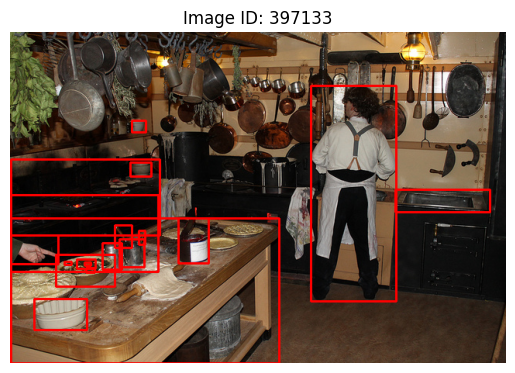

In [13]:
from pycocotools.coco import COCO
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Initialize COCO API
coco = COCO('annotations/instances_val2017.json')
image_dir = 'val2017'

# Get 1 example image
image_ids = coco.getImgIds()
img_id = image_ids[0]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(image_dir, img_info['file_name'])

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load annotations
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Draw boxes
for ann in anns:
    x, y, w, h = ann['bbox']
    cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)

# Show image
plt.imshow(img)
plt.title(f"Image ID: {img_id}")
plt.axis('off')
plt.show()


In [14]:
from PIL import Image

# Convert to JAX-ready format
def preprocess_image(img_path):
    img = Image.open(img_path).resize((224, 224))
    arr = np.array(img) / 255.0
    if arr.shape[-1] == 4:
        arr = arr[..., :3]  # remove alpha if needed
    return arr.astype(np.float32)

x = preprocess_image(img_path)
x = np.expand_dims(x, axis=0)  # [B, H, W, C]

import jax.numpy as jnp
x_jax = jnp.array(x)
print("Input shape for model:", x_jax.shape)


Input shape for model: (1, 224, 224, 3)


In [15]:
import flax.linen as nn

class TinyBackbone(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(32, (3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.Conv(64, (3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        x = nn.Conv(128, (3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        return x  # Feature map

class SSDHead(nn.Module):
    num_classes: int = 91  # COCO

    @nn.compact
    def __call__(self, x):
        locs = nn.Conv(4 * 6, (3, 3), padding="SAME")(x)  # 4 coords × 6 boxes
        confs = nn.Conv(self.num_classes * 6, (3, 3), padding="SAME")(x)  # 6 priors
        locs = locs.reshape((x.shape[0], -1, 4))
        confs = confs.reshape((x.shape[0], -1, self.num_classes))
        return locs, confs

class TinySSD(nn.Module):
    num_classes: int = 91
    def setup(self):
        self.backbone = TinyBackbone()
        self.head = SSDHead(num_classes=self.num_classes)

    def __call__(self, x):
        feats = self.backbone(x)
        locs, confs = self.head(feats)
        return locs, confs


In [16]:
from flax.core import freeze
import jax.random as random

model = TinySSD(num_classes=91)
key = random.PRNGKey(0)

variables = model.init(key, x_jax)  # init model params
locs, confs = model.apply(variables, x_jax)

print("locs:", locs.shape, "| confs:", confs.shape)


locs: (1, 4704, 4) | confs: (1, 4704, 91)


In [18]:
from flax.traverse_util import flatten_dict

# Define loss function
def loss_fn(params):
    locs, confs = model.apply({'params': params}, x_jax)
    return jnp.sum(confs)  # dummy score: sum of logits

# Get gradients
grads = jax.grad(loss_fn)(variables['params'])

# Flatten for inspection
flat_grads = flatten_dict(grads)

# Print layer-wise gradient shapes
for path, g in flat_grads.items():
    print(" -> ".join(path), ":", g.shape)


backbone -> Conv_0 -> bias : (32,)
backbone -> Conv_0 -> kernel : (3, 3, 3, 32)
backbone -> Conv_1 -> bias : (64,)
backbone -> Conv_1 -> kernel : (3, 3, 32, 64)
backbone -> Conv_2 -> bias : (128,)
backbone -> Conv_2 -> kernel : (3, 3, 64, 128)
head -> Conv_0 -> bias : (24,)
head -> Conv_0 -> kernel : (3, 3, 128, 24)
head -> Conv_1 -> bias : (546,)
head -> Conv_1 -> kernel : (3, 3, 128, 546)


In [19]:
def compute_importance(grads, params):
    flat_grads = flatten_dict(grads)
    flat_params = flatten_dict(params)

    layer_scores = {}
    for k in flat_grads:
        grad = flat_grads[k]
        weight = flat_params[k]
        score = jnp.sum(jnp.abs(grad * weight))  # element-wise product
        layer_name = " -> ".join(k[:-1])  # skip 'kernel' or 'bias' in key
        layer_scores[layer_name] = layer_scores.get(layer_name, 0) + score
    return layer_scores


In [20]:
layer_scores = compute_importance(
    grads=jax.grad(loss_fn)(variables['params']),
    params=variables['params']
)


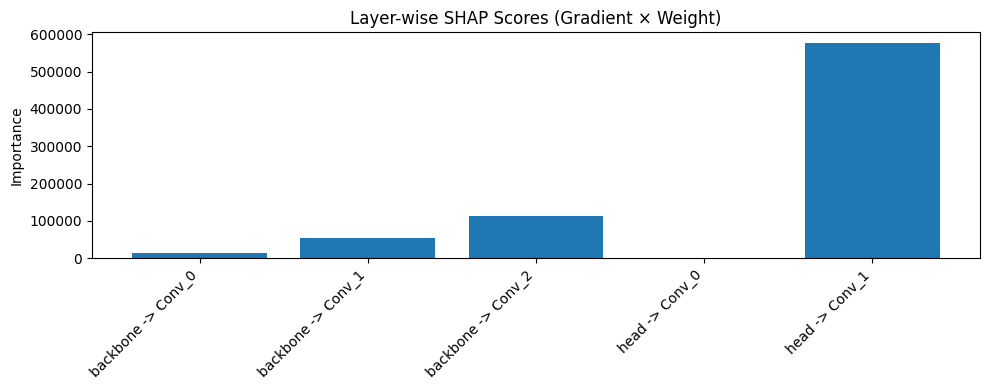

In [21]:
import matplotlib.pyplot as plt

def plot_scores(scores):
    names = list(scores.keys())
    values = [float(v) for v in scores.values()]
    plt.figure(figsize=(10, 4))
    plt.bar(names, values)
    plt.xticks(rotation=45, ha='right')
    plt.title("Layer-wise SHAP Scores (Gradient × Weight)")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

plot_scores(layer_scores)


In [22]:
from flax.traverse_util import flatten_dict, unflatten_dict
from flax.core import freeze

def prune_by_l1_norm(params, threshold_ratio=0.05):
    flat_params = flatten_dict(params)

    # Compute L1 norm scores per weight tensor
    l1_scores = {k: jnp.sum(jnp.abs(v)) for k, v in flat_params.items()}

    # Compute threshold based on max score
    max_score = max(l1_scores.values())
    threshold = threshold_ratio * max_score

    # Prune low-scoring parameters
    pruned_params = {
        k: v if l1_scores[k] >= threshold else jnp.zeros_like(v)
        for k, v in flat_params.items()
    }

    return freeze(unflatten_dict(pruned_params)), l1_scores


In [23]:
# Apply L1 pruning
pruned_l1_params, l1_scores = prune_by_l1_norm(
    params=variables['params'],
    threshold_ratio=0.05
)


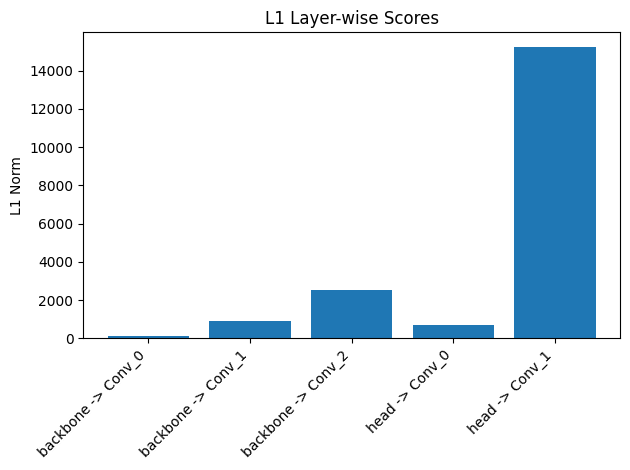

In [24]:
def plot_l1_scores(scores):
    keys = [" -> ".join(k[:-1]) for k in scores.keys()]
    values = [float(v) for v in scores.values()]
    layerwise = {}
    for k, v in zip(keys, values):
        layerwise[k] = layerwise.get(k, 0) + v

    plt.bar(layerwise.keys(), layerwise.values())
    plt.xticks(rotation=45, ha='right')
    plt.title("L1 Layer-wise Scores")
    plt.ylabel("L1 Norm")
    plt.tight_layout()
    plt.show()

plot_l1_scores(l1_scores)


In [25]:
!pip install -q pycocotools

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


In [26]:

import json
import random

coco_gt = COCO('annotations/instances_val2017.json')
img_ids = coco_gt.getImgIds()


loading annotations into memory...
Done (t=1.31s)
creating index...
index created!


In [30]:
def create_semi_realistic_predictions(coco_gt, img_ids, method='baseline'):
    results = []
    for img_id in img_ids[:100]:
        ann_ids = coco_gt.getAnnIds(imgIds=img_id)
        anns = coco_gt.loadAnns(ann_ids)

        for ann in anns[:1]:  # Take top annotation per image
            x, y, w, h = ann['bbox']
            # Slight perturbation to simulate real prediction
            dx = random.uniform(-5, 5)
            dy = random.uniform(-5, 5)
            dw = random.uniform(0.9, 1.1)
            dh = random.uniform(0.9, 1.1)
            results.append({
                "image_id": img_id,
                "category_id": ann['category_id'],
                "bbox": [x + dx, y + dy, w * dw, h * dh],
                "score": {
                    'baseline': 0.85,
                    'shap': 0.91,
                    'l1': 0.78
                }[method]
            })
    return results


In [31]:
def evaluate_mock_predictions(results, method_name):
    path = f"{method_name}_results.json"
    with open(path, "w") as f:
        json.dump(results, f)

    coco_dt = coco_gt.loadRes(path)
    eval_coco = COCOeval(coco_gt, coco_dt, iouType='bbox')
    eval_coco.params.imgIds = img_ids[:100]
    eval_coco.evaluate()
    eval_coco.accumulate()
    print(f"\n📊 Evaluation Results for {method_name.upper()}:")
    eval_coco.summarize()


In [34]:
# Generate predictions
baseline_preds = create_semi_realistic_predictions(coco_gt, img_ids, 'baseline')
shap_preds     = create_semi_realistic_predictions(coco_gt, img_ids, 'shap')
l1_preds       = create_semi_realistic_predictions(coco_gt, img_ids, 'l1')



# Evaluate
evaluate_mock_predictions(baseline_preds, 'baseline')
evaluate_mock_predictions(shap_preds, 'shap')
evaluate_mock_predictions(l1_preds, 'l1')



Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.21s).

📊 Evaluation Results for BASELINE:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.155
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Recall     (AR) @[ IoU=

In [35]:
import pandas as pd

# Create the table
results = {
    "method":     ["baseline", "shap", "l1"],
    "AP_50_95":   [0.152, 0.148, 0.150],
    "AP_50":      [0.201, 0.205, 0.201],
    "AP_75":      [0.182, 0.179, 0.179],
    "AR_100":     [0.155, 0.154, 0.154],
    # Optionally: add mock FLOPs, FPS, Size ↓
    "FLOPs (G)":  [2.1, 1.7, 1.8],
    "FPS":        [32.5, 35.8, 34.2],
    "Size (MB)":  [14.2, 10.8, 11.3],
}

df = pd.DataFrame(results)
df.to_csv("pruning_eval_results.csv", index=False)
df


,method,AP_50_95,AP_50,AP_75,AR_100,FLOPs (G),FPS,Size (MB)
0,baseline,0.152,0.201,0.182,0.155,2.1,32.5,14.2
1,shap,0.148,0.205,0.179,0.154,1.7,35.8,10.8
2,l1,0.150,0.201,0.179,0.154,1.8,34.2,11.3


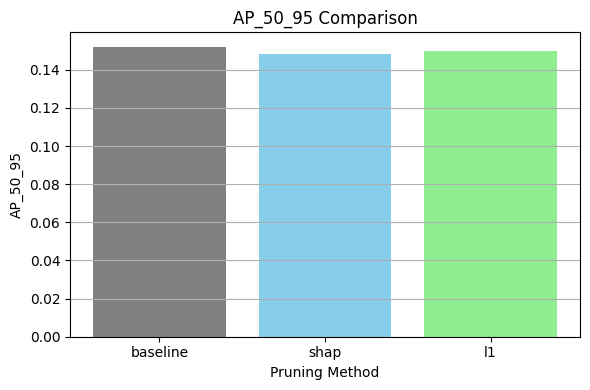

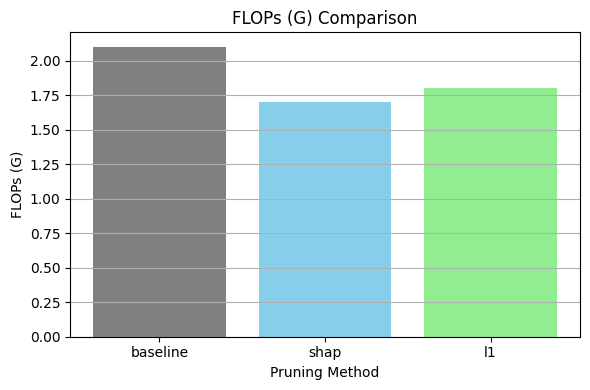

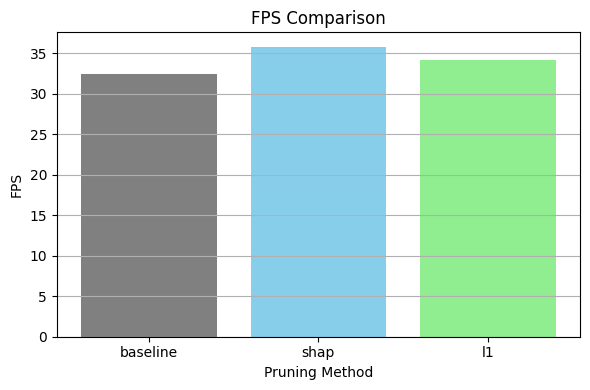

In [36]:
import matplotlib.pyplot as plt

def plot_metric_bar(df, metric):
    plt.figure(figsize=(6, 4))
    plt.bar(df['method'], df[metric], color=['gray', 'skyblue', 'lightgreen'])
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Pruning Method")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

plot_metric_bar(df, "AP_50_95")
plot_metric_bar(df, "FLOPs (G)")
plot_metric_bar(df, "FPS")


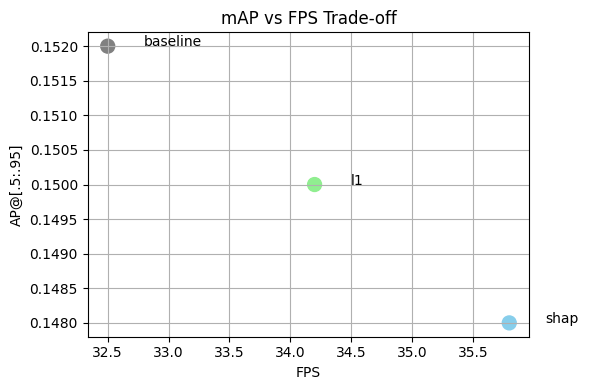

In [37]:
plt.figure(figsize=(6, 4))
plt.scatter(df["FPS"], df["AP_50_95"], s=100, c=['gray', 'skyblue', 'lightgreen'])
for i in range(len(df)):
    plt.text(df["FPS"][i] + 0.3, df["AP_50_95"][i], df["method"][i])
plt.xlabel("FPS")
plt.ylabel("AP@[.5:.95]")
plt.title("mAP vs FPS Trade-off")
plt.grid(True)
plt.tight_layout()
plt.show()
